In [71]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

import gensim

from tensorflow.keras.preprocessing.text import Tokenizer



In [72]:
df = pd.read_csv('pre-processed.csv')

In [73]:
df.shape

(7200, 3)

In [74]:
df.mean()

index    3599.5
dtype: float64

In [75]:
df.head()

,index,label,preprocessed_news
0,0,fake,katia abreu diz vai colocar expulsao moldura n...
1,1,fake,ray peita bolsonaro conservador fake entrevist...
2,2,fake,reinaldo azevedo desmascarado policia federal ...
3,3,fake,relatorio assustador bndes mostra dinheiro pub...
4,4,fake,radialista americano fala sobre pt vendem ilus...


In [76]:
#Target variable for fake news
df['output'] = df['label'].apply(lambda x: 0 if x == 'fake' else 1)


In [77]:
df=df.dropna()

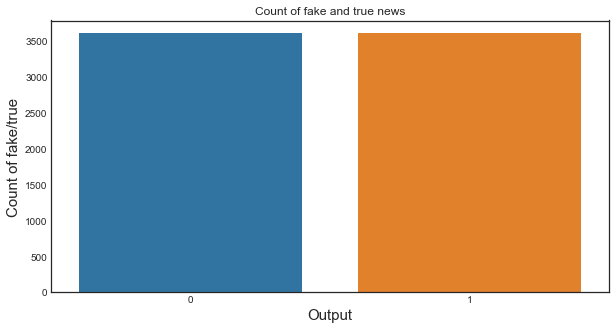

In [78]:
#Contagem de notícias falsas e notícias verdadeiras
#Vamos verificar a contagem de notícias falsas e verdadeiras e confirmar se nossos dados estão equilibrados

ax=sns.countplot(x="output", data=df)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

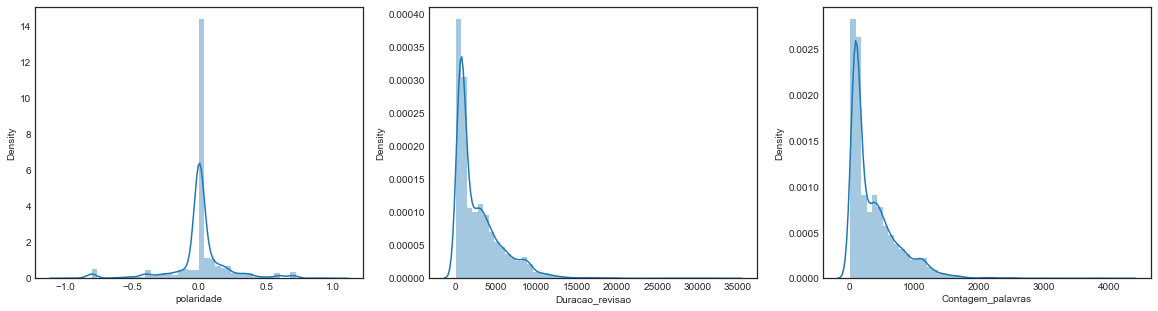

In [79]:
#Vamos extrair mais recursos das notícias, tais como
#Polaridade: A medida que significa o sentimento da notícia
#Duração da revisão: Comprimento da notícia (número de letras e espaços)
#Contagem de palavras: Número de palavras nas notícias


#Extracting the features from the news
df['polaridade'] = df['preprocessed_news'].map(lambda text: TextBlob(text).sentiment.polarity)
df['Duracao_revisao'] = df['preprocessed_news'].astype(str).apply(len)
df['Contagem_palavras'] = df['preprocessed_news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polaridade'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['Duracao_revisao'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['Contagem_palavras'])
fig = plt.gcf()

A maior parte da polaridade é neutra, nem mostra más notícias nem muitas notícias felizes
A contagem de palavras está entre 0-2000 e a extensão da notícia está entre 0-10000 e poucas perto de 15000 palavras, o que poderia ser um artigo

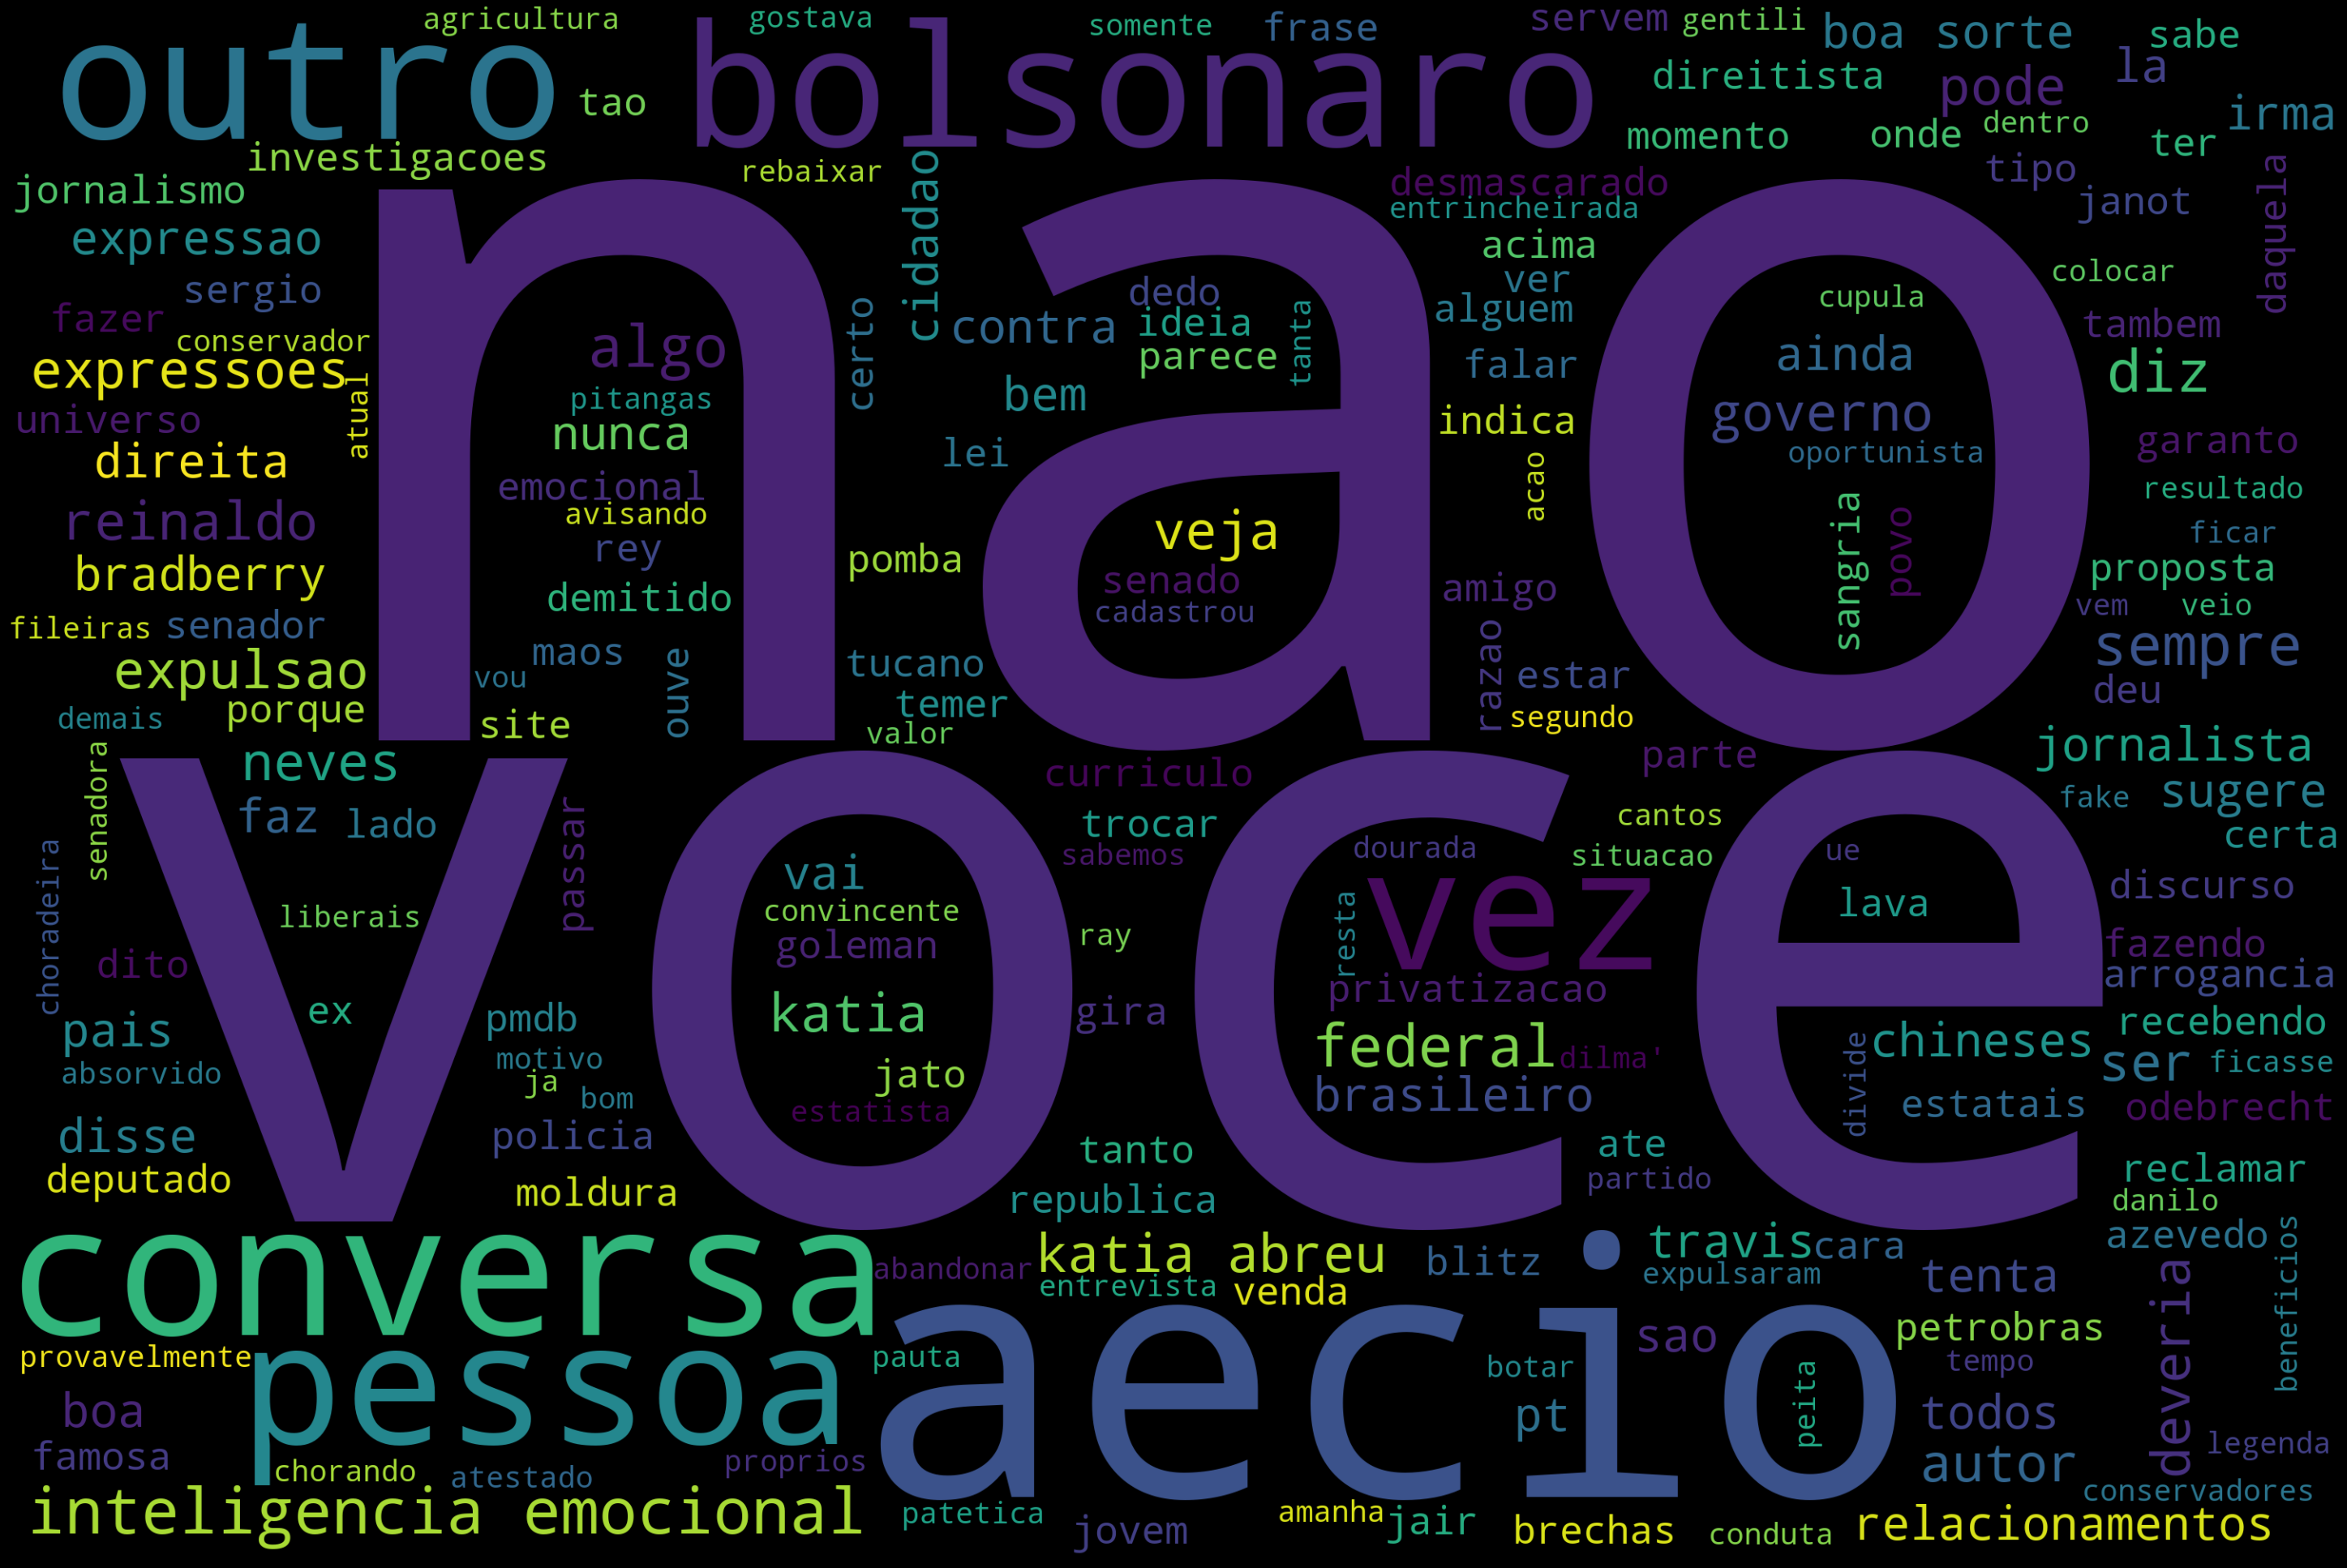

In [80]:
#WordCloud de Notícias Falsas e Verdadeiras ?
#Vamos olhar para a palavra nuvem para notícias falsas e verdadeiras

#fake
text = df.loc[df.output==0,'preprocessed_news'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

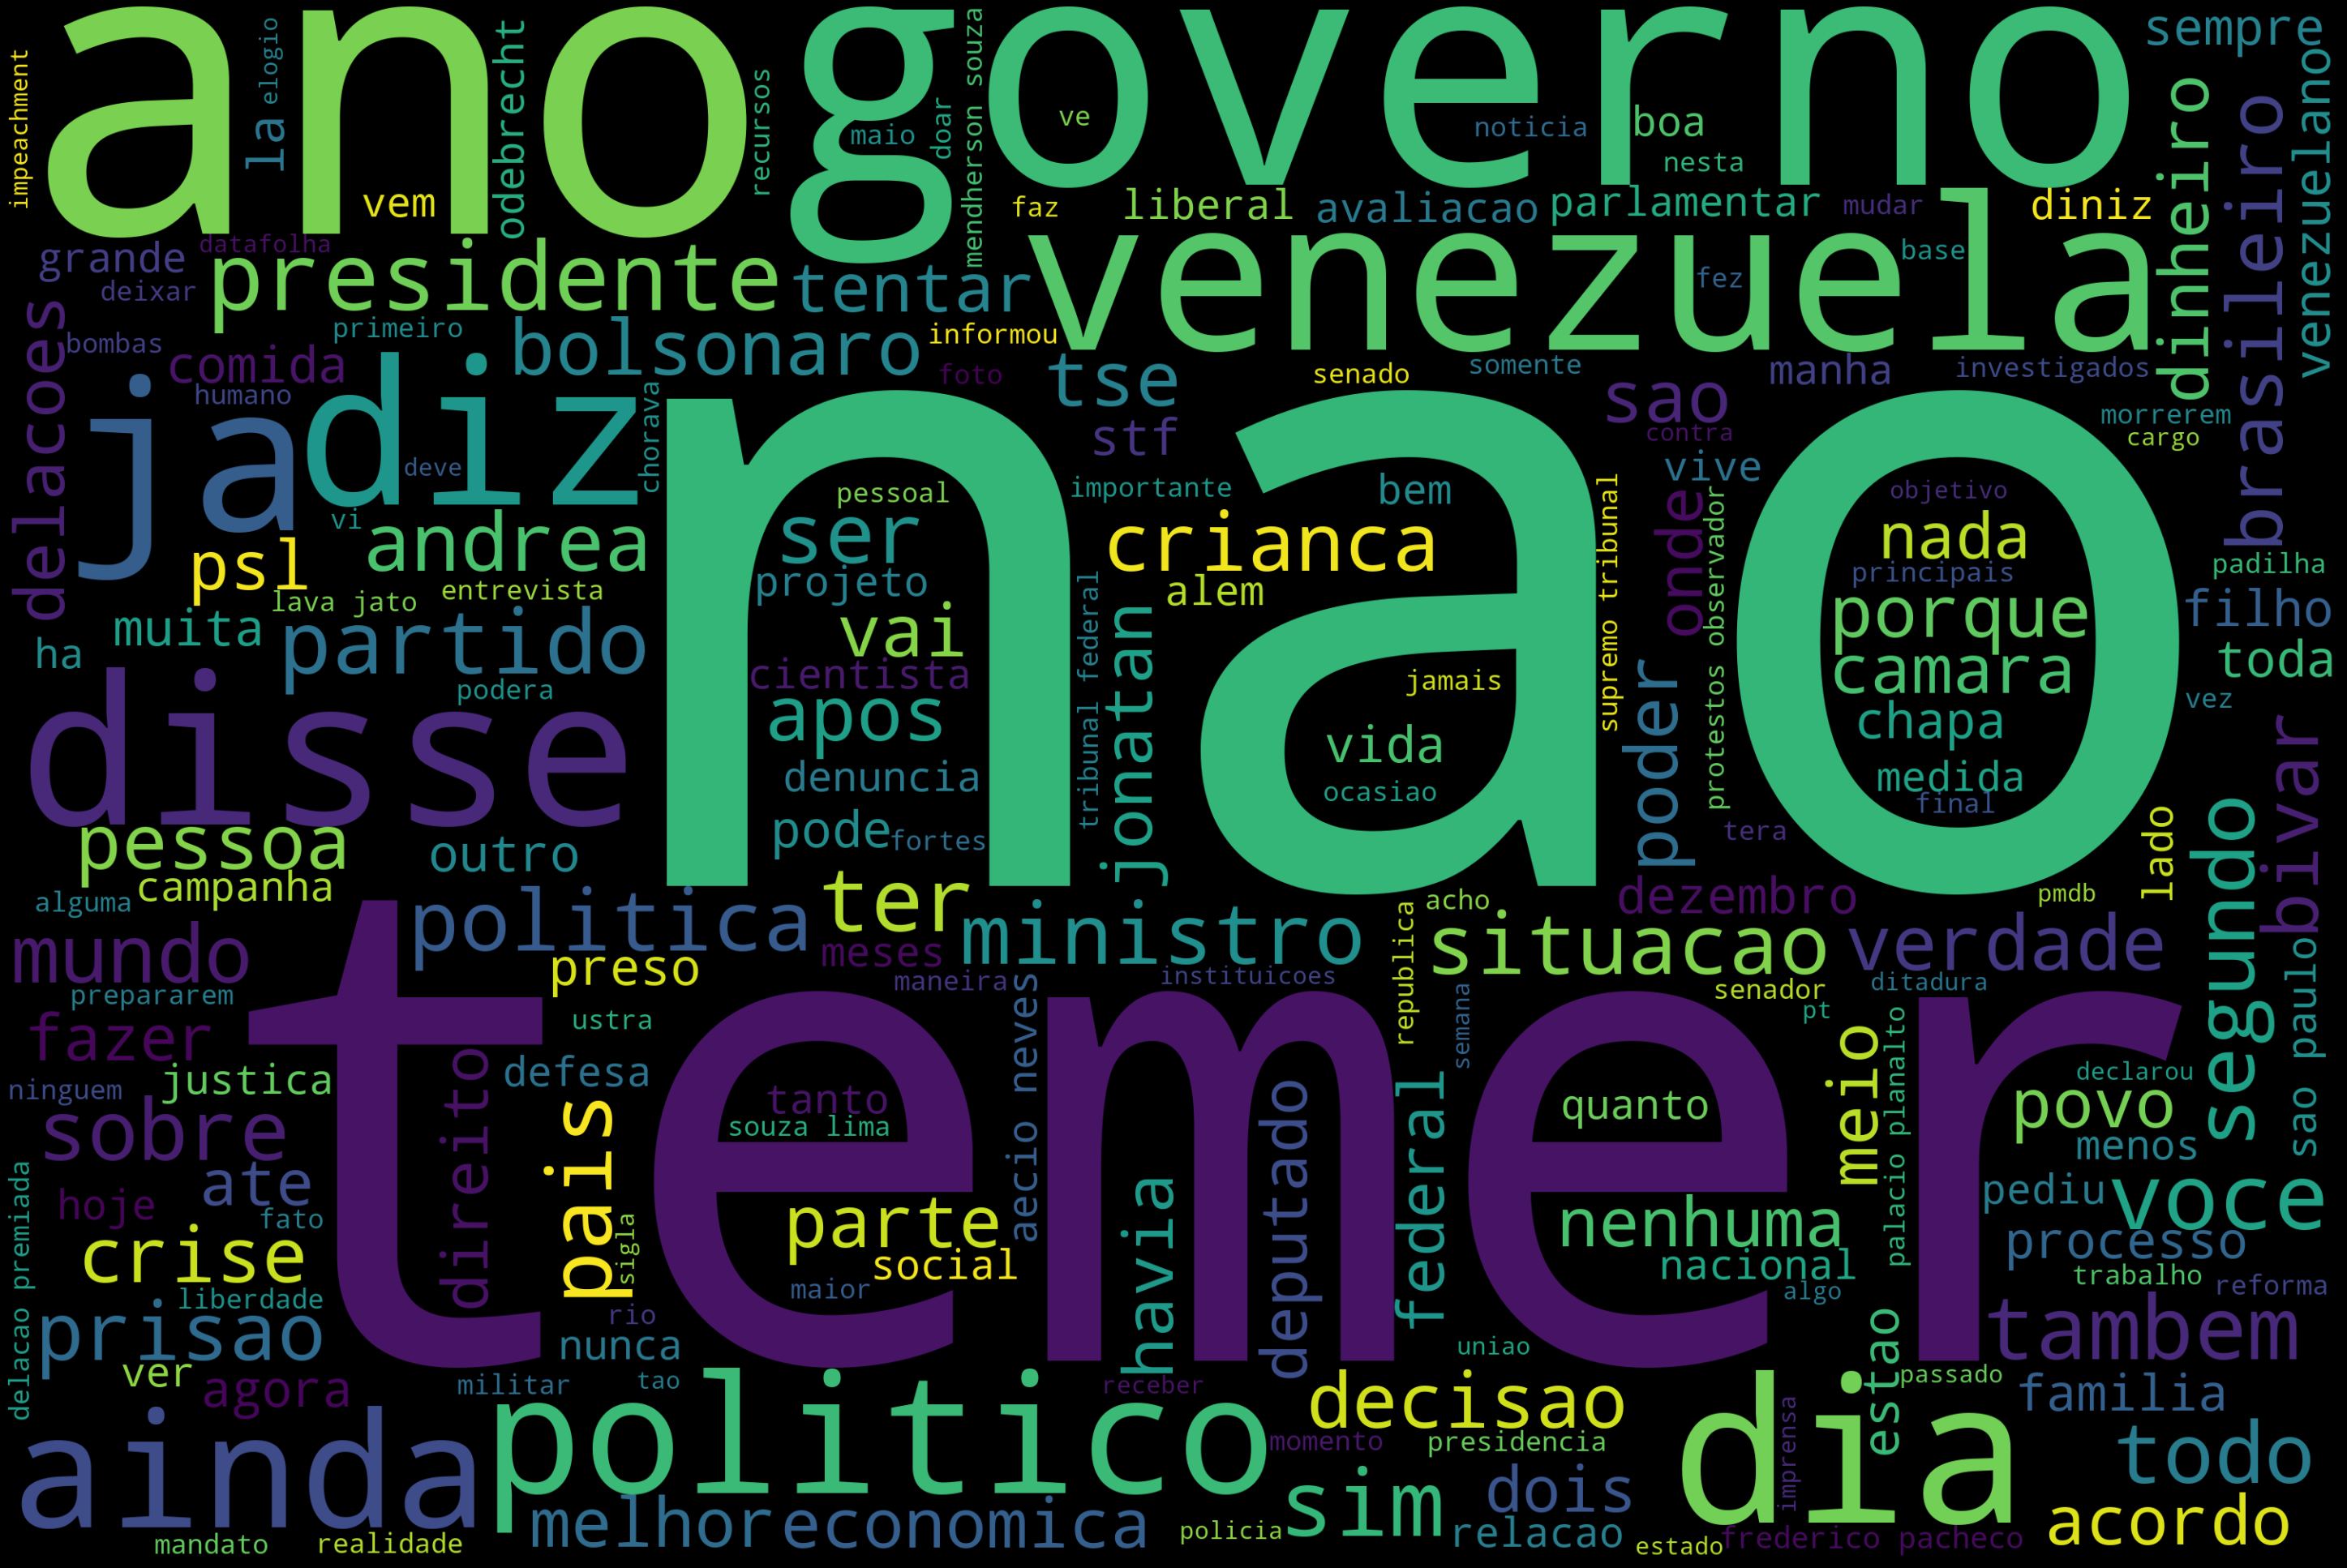

In [81]:
#WordCloud de Notícias Falsas e Verdadeiras ?
#Vamos olhar para a palavra nuvem para notícias falsas e verdadeiras

#real
text = df.loc[df.output==1,'preprocessed_news'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [82]:
#Corte e Vetorização
#Como resultado das revisões
#A derivação é um método de derivar a palavra de raiz a partir da palavra inflectida. Aqui extraímos as revisões e convertemos as palavras em revisões para sua palavra de raiz, por exemplo,

#Indo->vindo
#Finalmente->fina
#Se você notar, as palavras de raiz não precisam ter um significado semântico. Há outra técnica conhecida como Lemmatização onde converte as palavras em palavras-raiz que têm um significado semântico. Sim, isso leva tempo. Estou usando o stemming

#Extracting 'reviews' for processing
news_features=df.copy()
news_features=df[['preprocessed_news']].reset_index(drop=True)
news_features.head()

,preprocessed_news
0,katia abreu diz vai colocar expulsao moldura n...
1,ray peita bolsonaro conservador fake entrevist...
2,reinaldo azevedo desmascarado policia federal ...
3,relatorio assustador bndes mostra dinheiro pub...
4,radialista americano fala sobre pt vendem ilus...


In [83]:
corpus = []
for i in range(0, len(news_features)):
    review = re.sub('[^a-zA-Z]', ' ', news_features['preprocessed_news'][i])
    review = review.lower()
    review = review.split()
 
    #review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
corpus[0]

'katia abreu diz vai colocar expulsao moldura nao reclamar senadora katia abreu disse expulsao pmdb resultado acao cupula atual legenda segundo oportunista amanha vou botar moldura dourada expulsao porque maos onde veio atestado boa conduta curriculo pessoas expulsaram nao servem pais servem pais beneficios proprios disse katia abreu ue expulsao algo tao bom curriculo tanta choradeira katia sabemos motivo provavelmente katia nao valor pt partido ja deveria absorvido parece pt gostava katia somente ficasse entrincheirada dentro pmdb rebaixar demais resta katia ficar chorando pitangas todos cantos tempo ate momento pt nao cadastrou katia abreu fileiras situacao patetica agricultura dilma'

### É assim que uma linha se parece agora, já que o computador não consegue entender as palavras e seus sentimentos, precisamos converter essas palavras em 1's e 0's. Para codificá-la, usamos TFIDF

TFIDF(Term Frequency - Frequência do Documento Inverso)
TF-IDF significa "Term Frequency - Inverse Document Frequency" (Frequência do Termo - Frequência Inversa do Documento). Esta é uma técnica para quantificar uma palavra em documentos, geralmente calculamos um peso para cada palavra, o que significa a importância da palavra no documento e no corpus. Este método é uma técnica amplamente utilizada em Recuperação de Informação e Mineração de Texto.

Aqui estamos nos dividindo como bigram (duas palavras) e consideramos seu peso combinado. Também estamos pegando apenas as 5000 palavras mais importantes das notícias.



In [84]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['preprocessed_news'])
X.shape

(7200, 5000)

In [85]:
#Getting the target variable
y=df['output']
y

0       0
1       0
2       0
3       0
4       0
       ..
7195    1
7196    1
7197    1
7198    1
7199    1
Name: output, Length: 7200, dtype: int64

Verificação do equilíbrio dos dados
Devemos ter cuidado ao tratar os dados de desequilíbrio. Se for desequilibrado, o modelo será enviesado para a classe de freqüência mais alta e retornará a saída máxima

In [86]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({0: 3600, 1: 3600})


In [87]:
#Dividir o teste do Train-test(75:25)
#Usando a função de divisão de teste de Train, estamos dividindo o conjunto de dados em proporção de 75:25 para o Train e o conjunto de teste, respectivamente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)



Construção de modelos: Classificador de notícias falsas
Como processamos com sucesso os dados de texto, não se trata apenas de um problema normal de aprendizagem da máquina. De onde, a partir da matriz esparsa, prevemos as aulas na característica alvo.


### Seleção de modelos
Primeiramente, selecione o melhor modelo de peforming usando o cross validaton. Vamos considerar todo o algoritmo de classificação e realizar o processo de seleção do modelo

Nota: Eu não estou incluindo SVM neste algoritmo porque demorou muito tempo para treinar no meu dispositivo

In [88]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
svm = LinearSVC()
cc_svm = CalibratedClassifierCV(svm)
rfc = RandomForestClassifier()
##gnb = GaussianNB()

cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes', 4:'Linear SVC', 5: 'Calibrated ClassifierCV', 6: 'Random Forest Classifier'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv,svm,cc_svm,rfc]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.9295833333333334
Decision Tree Test Accuracy: 0.8543055555555557
KNN Test Accuracy: 0.5343055555555555
Naive Bayes Test Accuracy: 0.8538888888888888
Linear SVC Test Accuracy: 0.9358333333333333
Calibrated ClassifierCV Test Accuracy: 0.9373611111111112
Random Forest Classifier Test Accuracy: 0.9347222222222223


#### A partir dos resultados, podemos ver a regressão logística ultrapassada pelo resto dos algoritmos seguidos por Naive Bayes e Decision Tree, o que é ótimo. Então vamos com a regressão logística com ajuste do hiperparâmetro.


Regressão logística com ajuste hiperparamétrico
Usamos parâmetro de regularização e penalidade para o ajuste de parâmetros. vamos ver qual deles conectar.

In [89]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=11.513953993264458, random_state=0)
The mean accuracy of the model is: 0.9405555555555556


In [90]:
#From the selected params, we get accuracy. Let's plug and chug
logreg = LogisticRegression(C=24.420530945486497, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


Temos uma precisão de 94%. Como já discutido anteriormente, este é um conjunto de dados tendencioso e podemos facilmente obter uma precisão tão maior sem nenhum esforço no processamento. Mas para problemas de classificação precisamos obter matriz de confusão e verificar a pontuação f1 em vez de precisão.

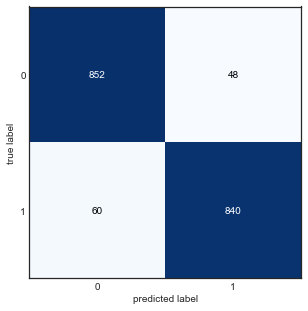

In [91]:
#Matriz de Confusão
#Vejamos o verdadeiro positivo e o verdadeiro negativo classificados pelo modelo

cm = metrics.confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm, classes=['Fake','True'])

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()


Confira os elementos diagonais (852+840), eles são registros corretamente previstos e o resto é classificado incorretamente pelo algoritmo. Nosso modelo tem se saído bem(os resultados são bons pelos dados são tendenciosos 

In [92]:
#Relatório de classificação Considerando Falsas notícias, devemos considerar seriamente a pontuação de precisão (Falso positivo).
#Não podemos cometer os erros quando o modelo classifica notícias falsas como verdadeiras, o que levará ao caos.

print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       900
           1       0.95      0.93      0.94       900

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



Todas as nossas pontuações são de 94%. Certamente irreal para obter tais valores. Há apenas mudanças no suporte.

### ROC-AUC Curve
Esta é uma curva muito importante na qual decidimos qual o limite a ser estabelecido com base nos critérios objetivos

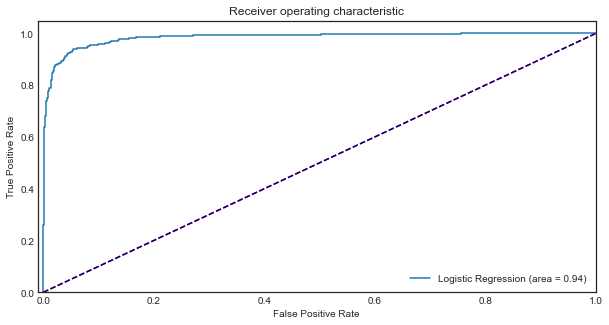

In [93]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


#Devemos considerar aqui a pontuação da AUC que é de 94%. Muito bem. Todas as métricas estão funcionando bem. 
#Quanto mais à esquerda a curva é melhor nosso modelo Podemos ajustar nosso limiar com base em nossa curva ROC para obter resultados com base nos requisitos do modelo.

### Vetorização -- Word2Vec
Word2Vec é uma das técnicas mais populares para aprender incrustações de palavras usando uma rede neural rasa. Ele foi desenvolvido por Tomas Mikolov em 2013 no Google.

A incorporação de palavras é a representação mais popular do vocabulário de documentos. É capaz de capturar o contexto de uma palavra em um documento, similaridade semântica e sintática, relação com outras palavras, etc.



In [94]:
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["preprocessed_news"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [95]:
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer

#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X,vector_size=EMBEDDING_DIM, window=5, min_count=1)



In [96]:
#vocab size
len(w2v_model.wv.index_to_key)

#We have now represented each of 122248 words by a 100dim vector.

79441

In [97]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [98]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[3731, 2407, 21, 26, 833, 5608, 29667, 1, 5998, 1355]

In [99]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break 

nao -> 1
lula -> 2
ser -> 3
tambem -> 4
sao -> 5
presidente -> 6
disse -> 7
sobre -> 8
anos -> 9
ja -> 10


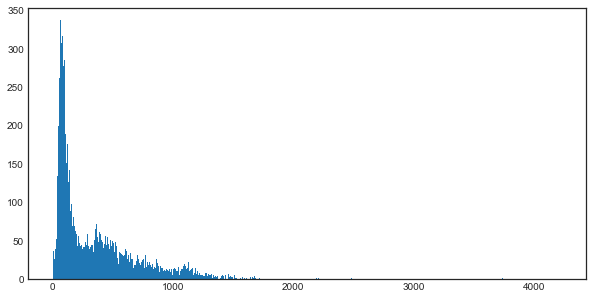

In [100]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [101]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

6018

In [102]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [103]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [104]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [105]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

Criamos uma matriz de mapeamento entre o índice de palavras e os vetores. Utilizamos isto como pesos na camada de embutimento

A camada de incorporação aceita a numeração da palavra e produz o vercor correspondente à camada interna.

Envia vetor de zeros para a camada seguinte para palavras desconhecidas que seriam simbólicas a 0.

O comprimento de entrada da camada de incorporação é o comprimento de cada notícia (700 agora devido ao acolchoamento e truncamento).


# Padding embedded documents
Documentos embutidos com estofamento 
Todas as redes neurais precisam ter insumos que tenham a mesma forma e tamanho. Entretanto, quando processamos e usamos os textos como inputs para nosso modelo LSTM, nem todas as frases têm o mesmo comprimento. Em outras palavras, naturalmente, algumas das sentenças são mais longas ou mais curtas. Precisamos ter as entradas com o mesmo tamanho, aqui é onde o acolchoamento é necessário. Aqui tomamos o comprimento comum como 3599 e executamos o estofamento usando a função pad_sequence() . Também vamos "pré" almofadar para que sejam adicionados zeros antes das sentenças para fazer a sentença de igual comprimento

In [106]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [107]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))


# LSTM Model
No início, vamos desenvolver o modelo básico e compilá-lo. A primeira camada será a camada embutida que tem a entrada do tamanho do vocabulário, características vetoriais e comprimento da frase. Mais tarde, adicionamos 30% de camada de dropout para evitar a sobreposição e a camada LSTM que tem 100 neurônios na camada. Na camada final, usamos a função de ativação sigmóide. Mais tarde, compilamos o modelo usando o otimizador adam e a entropia cruzada binária como função de perda, uma vez que temos apenas duas saídas.

Para entender como o LSTM funciona, por favor, verifique este link. Para dar uma pequena visão geral sobre como o LSTM funciona, ele se lembra apenas da importante seqüência de palavras e esquece as palavras insignificantes que não agregam valor na previsão.

In [108]:
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [109]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 700, 100)          7944200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,061,577
Trainable params: 117,377
Non-trainable params: 7,944,200
_________________________________________________________________


In [110]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 

In [111]:
model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
119/119 [==============================] - 42s 341ms/step - loss: 0.6281 - acc: 0.6396 - val_loss: 0.6783 - val_acc: 0.5521
Epoch 2/10
119/119 [==============================] - 42s 349ms/step - loss: 0.6122 - acc: 0.6541 - val_loss: 0.5901 - val_acc: 0.6878
Epoch 3/10
119/119 [==============================] - 41s 349ms/step - loss: 0.5622 - acc: 0.7026 - val_loss: 0.5463 - val_acc: 0.7329
Epoch 4/10
119/119 [==============================] - 42s 349ms/step - loss: 0.3801 - acc: 0.8367 - val_loss: 0.1816 - val_acc: 0.9408
Epoch 5/10
119/119 [==============================] - 42s 357ms/step - loss: 0.3730 - acc: 0.8351 - val_loss: 0.4362 - val_acc: 0.8378
Epoch 6/10
119/119 [==============================] - 42s 349ms/step - loss: 0.2079 - acc: 0.9352 - val_loss: 0.1624 - val_acc: 0.9439
Epoch 7/10
119/119 [==============================] - 43s 358ms/step - loss: 0.1409 - acc: 0.9518 - val_loss: 0.1453 - val_acc: 0.9451
Epoch 8/10
119/119 [==============================] - 4

In [112]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

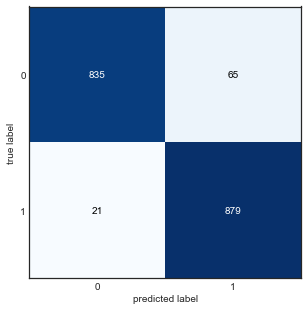

In [113]:
#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [114]:
accuracy_score(y_test, y_pred)

0.9522222222222222

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       900
           1       0.93      0.98      0.95       900

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800



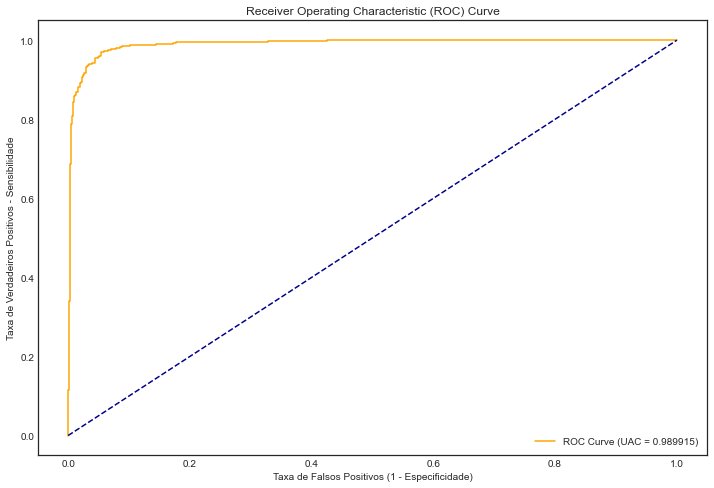

In [116]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))

auc = metrics.roc_auc_score(y_test, model.predict(X_test))

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()


In [119]:
print(pd.crosstab(y_test, y_pred.flatten(), rownames=['Real'], colnames=['Predito'], margins=True),'\n')

Predito    0    1   All
Real                   
0        835   65   900
1         21  879   900
All      856  944  1800 



### Usando vetores Word2Vec pré-treinados
Necessita de 12GB de RAM e 4GB de espaço HardDisk

Agora, em vez de criar vetores de palavras, vamos usar vetores pré-treinados treinados em parte do conjunto de dados do Google News (cerca de 100 bilhões de palavras). O modelo contém 300 vetores dimensionais para 3 milhões de palavras e frases. Fonte: https://code.google.com/archive/p/word2vec/

Por favor, baixe o arquivo do modelo em: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

Ou adicione Dataset de https://www.kaggle.com/sandreds/googlenewsvectorsnegative300


In [120]:
#invoke garbage collector to free ram
import gc
gc.collect()

5182

In [121]:
from gensim.models.keyedvectors import KeyedVectors

In [122]:
# Takes RAM 
word_vectors = KeyedVectors.load_word2vec_format('C:\Facens\TCC\GoogleNews-vectors-negative300.bin', binary = True)
EMBEDDING_DIM=300

In [123]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)


In [124]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [125]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 700, 300)          23832600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 697, 4)            4804      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 348, 4)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 23,905,629
Trainable params: 73,029
Non-trainable params: 23,832,600
_________________________________________________________________


In [126]:
model.fit(X_train, y_train, validation_split=0.3, epochs=12)

Epoch 1/12
119/119 [==============================] - 22s 180ms/step - loss: 0.6849 - acc: 0.5438 - val_loss: 0.7068 - val_acc: 0.4941
Epoch 2/12
119/119 [==============================] - 22s 182ms/step - loss: 0.6868 - acc: 0.5427 - val_loss: 0.6679 - val_acc: 0.5996
Epoch 3/12
119/119 [==============================] - 22s 187ms/step - loss: 0.6107 - acc: 0.6666 - val_loss: 0.5999 - val_acc: 0.6804
Epoch 4/12
119/119 [==============================] - 22s 187ms/step - loss: 0.4649 - acc: 0.7748 - val_loss: 0.7470 - val_acc: 0.7458
Epoch 5/12
119/119 [==============================] - 22s 188ms/step - loss: 0.5133 - acc: 0.7507 - val_loss: 0.6786 - val_acc: 0.5836
Epoch 6/12
119/119 [==============================] - 23s 192ms/step - loss: 0.4678 - acc: 0.7809 - val_loss: 0.7459 - val_acc: 0.6360
Epoch 7/12
119/119 [==============================] - 23s 190ms/step - loss: 0.2138 - acc: 0.9227 - val_loss: 0.2712 - val_acc: 0.9087
Epoch 8/12
119/119 [==============================] - 2

In [127]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

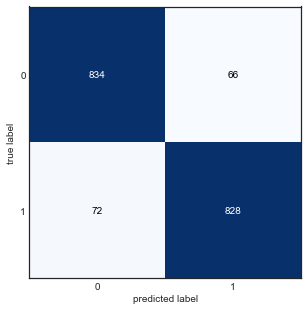

In [128]:
#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [129]:
accuracy_score(y_test, y_pred)

0.9233333333333333

In [130]:
print(
    (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       900
           1       0.93      0.92      0.92       900

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



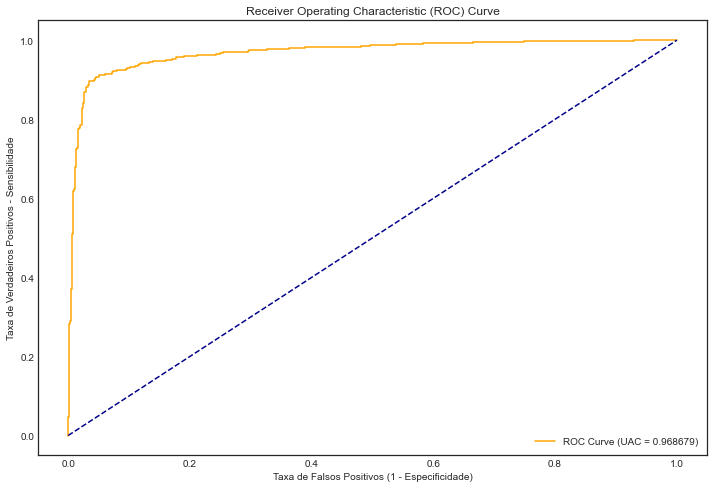

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))

auc = metrics.roc_auc_score(y_test, model.predict(X_test))

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, color='orange', label='ROC Curve (UAC = ' + str(auc.round(6)) + ')')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos - Sensibilidade')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4)
plt.show()


In [132]:
print(pd.crosstab(y_test, y_pred.flatten(), rownames=['Real'], colnames=['Predito'], margins=True),'\n')

Predito    0    1   All
Real                   
0        834   66   900
1         72  828   900
All      906  894  1800 

